In [2]:
#x^2+y^2 = r^2

import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import cv2

args = {
    'latent_dim':32,
    'lr':0.0001,
    'epochs':100,
    'batch_size' : 32,
    'train_len' : 50000,
    'eval_len' : 10000
}
to_pil_image= transforms.ToPILImage()

In [3]:


def rectangleOrCircle():
    if(np.random.uniform(0,1)) >= 0.5:
        return 'rectangle'
    else:
        return 'circle'


def randParamsNumpy():
    x = np.random.randint(low = 8,high = 25)
    y = np.random.randint(low = 8,high = 25)
    size = np.random.randint(low = 3,high = 9)
    return x,y,size

def pickColor(only_rand_blue = False):
    if(only_rand_blue == True):
        red = 0
        green = 0
        blue = np.random.uniform(0,1)
    else:
        red = np.random.uniform(0,1)
        green = np.random.uniform(0,1)
        blue = np.random.uniform(0,1)
    return red,green,blue

def randParamsPytorch():
    x = torch.randint(low = 8,high = 25,size = (1,1))[0][0]
    y = torch.randint(low = 8,high = 25,size = (1,1))[0][0]
    size = torch.randint(low = 3,high = 9,size = (1,1))[0][0]
    return x,y,size

 
def createSquare(only_rand_blue = False):
    x,y,size = randParamsPytorch()
    red,green,blue = pickColor(only_rand_blue)
    z = torch.zeros(3,32,32) #or torch.ones for white background
    z[0][:,x-size:x+size][y-size:y+size] = red
    z[1][:,x-size:x+size][y-size:y+size] = green
    z[2][:,x-size:x+size][y-size:y+size] = blue
    return z
#,[x,y,size]

def createCircle(only_rand_blue = False):
    
    x,y,size = randParamsPytorch()
    red,green,blue = pickColor(only_rand_blue)
    z = torch.zeros(3,32,32) #or torch.ones for white background
    
    X = np.random.multivariate_normal([0, 0], [[1, 0], [0,1]], 10000)
    Z = X / 10 + X / np.sqrt(np.square(X).sum(axis=1, keepdims=True))
    #plt.plot(np.floor(size*np.array(Z[:,0])),np.floor(size*np.array(Z[:,1])),'x')
    new_dict = {}
    grouped_x = pd.DataFrame({'x':np.floor(size*np.array(Z[:,0])),'y':np.floor(size*np.array(Z[:,1]))}).groupby(by='x')
    for i in grouped_x:
        val_x1 = min([j if j>0 else 20 for j in i[1]['y']] )
        val_x2 = max([j if j<0 else -20 for j in i[1]['y']])
        val_x1 = val_x1+size+(x-size)
        val_x2= val_x2+size+(x-size)
        
        new_dict[(int(i[0]+size+(y-size)))] = [(int(val_x2)),(int(val_x1))]
#ask if size is radius or total size  
    #print(f'new_dct is {new_dict}')
    for i in range(2*size):
        y_axis = int(i+(y-size))
        bounds = new_dict[y_axis]
        
        #print(f'the bounds are{bounds}, size is {size} and x and y are {x},{y}')
        z[0][:,bounds[0]:bounds[1]][32-y_axis-1] = red
        z[1][:,bounds[0]:bounds[1]][32-y_axis-1] = green
        z[2][:,bounds[0]:bounds[1]][32-y_axis-1] = blue
        
    return z


In [4]:
import math
from skimage.draw import circle
to_pil_image= transforms.ToPILImage()

def createCircleNewTry(only_rand_blue=False):
    x,y,size = randParamsPytorch()
    red,green,blue = pickColor(only_rand_blue)
    img = torch.zeros((3,32,32))
    rr,cc = circle(r = x,c = y,radius = size)
    img[0][rr, cc] = red
    img[1][rr, cc] = green
    img[2][rr, cc] = blue
    return img

In [5]:
def createCircleNewestTry(only_rand_blue = False):
    to_pil_image= transforms.ToPILImage()
    x,y,size = randParamsNumpy()
    red,green,blue = pickColor(only_rand_blue)
    z = np.zeros((32,32,3))
    cv2.circle(z,(x,y),size,(red,green,blue),-1)
    z = np.transpose(z,[2,0,1])
    z = torch.FloatTensor(z)
    return z
#,[x,y,size]

def createSquareNewestTry(only_rand_blue = False):
    to_pil_image= transforms.ToPILImage()
    x,y,size = randParamsNumpy()
    red,green,blue = pickColor(only_rand_blue)
    z = np.zeros((32,32,3))
    cv2.rectangle(z,(x,y),(x+size,y+size),(red,green,blue),-1)
    z = np.transpose(z,[2,0,1])
    z = torch.FloatTensor(z)

    return z
#,[x,y,size]


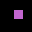

In [6]:
to_pil_image(createSquareNewestTry())

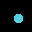

In [7]:
to_pil_image(createCircleNewTry())

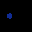

In [8]:

to_pil_image(createCircle())

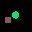

In [9]:
to_pil_image(createSquare() + createCircle())

In [11]:
#creating synthetic dataset
#compress maybe?
def train_set_twoShapes(size = args['train_len']):
    dataset = []
    for i in range(size):
        if(i%500==0):
            print(f' this is the {i}th iteration')
        #if(np.random.randint(0,2) == 0):
        #    dataset.append(createCircle())
        #else:
        dataset.append(createSquareNewestTry()+createCircleNewestTry())
        
    return dataset

In [12]:
def eval_set_twoShapes(size = args['eval_len']):
    dataset = []
    for i in range(size):
        if(i%500==0):
            print(f' this is the {i}th iteration')
        #if(np.random.randint(0,2) == 0):
        #    dataset.append(createCircle())
        #else:
        dataset.append(createSquareNewestTry()+createCircleNewestTry())
    return dataset
    

In [37]:
def train_set(size = args['train_len']):
    dataset = []
  
    for i in range(size):
        if(i%500==0):
            print(f' this is the {i}th iteration')
        if(np.random.randint(0,2) == 0):
            data = createCircleNewestTry()
            dataset.append(data)
        else:
            data = createSquareNewestTry()
            dataset.append(data)
               
    return dataset

In [38]:
def eval_set(size = args['eval_len']):
    dataset = []

    for i in range(size):
        if(i%500==0):
            print(f' this is the {i}th iteration')
        if(np.random.randint(0,2) == 0):
            data = createCircleNewestTry()
            dataset.append(data)         
        else:
            data = createSquareNewestTry()
            dataset.append(data)         
    return dataset

In [39]:
train_data = train_set()

 this is the 0th iteration
 this is the 500th iteration
 this is the 1000th iteration
 this is the 1500th iteration
 this is the 2000th iteration
 this is the 2500th iteration
 this is the 3000th iteration
 this is the 3500th iteration
 this is the 4000th iteration
 this is the 4500th iteration
 this is the 5000th iteration
 this is the 5500th iteration
 this is the 6000th iteration
 this is the 6500th iteration
 this is the 7000th iteration
 this is the 7500th iteration
 this is the 8000th iteration
 this is the 8500th iteration
 this is the 9000th iteration
 this is the 9500th iteration
 this is the 10000th iteration
 this is the 10500th iteration
 this is the 11000th iteration
 this is the 11500th iteration
 this is the 12000th iteration
 this is the 12500th iteration
 this is the 13000th iteration
 this is the 13500th iteration
 this is the 14000th iteration
 this is the 14500th iteration
 this is the 15000th iteration
 this is the 15500th iteration
 this is the 16000th iteration
 

In [40]:
validation_data = eval_set()

 this is the 0th iteration
 this is the 500th iteration
 this is the 1000th iteration
 this is the 1500th iteration
 this is the 2000th iteration
 this is the 2500th iteration
 this is the 3000th iteration
 this is the 3500th iteration
 this is the 4000th iteration
 this is the 4500th iteration
 this is the 5000th iteration
 this is the 5500th iteration
 this is the 6000th iteration
 this is the 6500th iteration
 this is the 7000th iteration
 this is the 7500th iteration
 this is the 8000th iteration
 this is the 8500th iteration
 this is the 9000th iteration
 this is the 9500th iteration


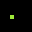

In [41]:
train_tensor_data = (torch.tensor(np.reshape((np.concatenate(train_data)),[50000,3,32,32])))
to_pil_image(train_tensor_data[90])

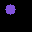

In [42]:
eval_tensor_data = (torch.tensor(np.reshape((np.concatenate(validation_data)),[10000,3,32,32])))
to_pil_image(eval_tensor_data[109])

In [ ]:
def gaussianNoise(train_tensor = train_tensor, mean = 0,var = 0.000009 ,size = args['train_len']):
    train_tensor_gaussian_noise = []
    #best so far has been var = 0.000009
    for i in range(size):
        if(i%500==0):
            print(f'this is the {i}th iteration')
        image = train_tensor[i]
        row,col,ch= image.shape
        gaussian_mean = float(mean)
        gaussian_var = float(var)
        sigma = float(gaussian_var**0.5)
        gauss = torch.normal(gaussian_mean,sigma,(row,col,ch))
        gauss = torch.reshape(gauss,(row,col,ch))
        noisy = image + gauss
        train_tensor_gaussian_noise.append(noisy)
    return train_tensor_gaussian_noise


In [ ]:
def normalize(size = args['train_len'],train_tensor = train_tensor):
    normalized_tensor = []
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    for i in range(size):
        if(i%500==0):
            print(f'this is the {i}th iteration')
        normalized_tensor.append(normalize(train_tensor[i]))
    return normalized_tensor
        

In [ ]:
#probability must be 1/something
def randomizedGaussianNoise(train_tensor = train_tensor, mean = 0,var = 0.000009 ,size = args['train_len'], probability = 0.5):
    train_tensor_gaussian_noise = []
    #best so far has been var = 0.000009
    for i in range(size):
        if(i%500==0):
            print(f'this is the {i}th iteration')
        image = train_tensor[i]
        if(np.random.randint(0,probability**-1) == 0): #high is exclusive
            row,col,ch= image.shape
            gaussian_mean = float(mean)
            gaussian_var = float(var)
            sigma = float(gaussian_var**0.5)
            gauss = torch.normal(gaussian_mean,sigma,(row,col,ch))
            gauss = torch.reshape(gauss,(row,col,ch))
            noisy = image + gauss
            train_tensor_gaussian_noise.append(noisy)
        else:
            train_tensor_gaussian_noise.append(image)
            
    return train_tensor_gaussian_noise

In [ ]:
def randomizedNormalization(train_tensor = train_tensor,size = args['train_len'], probability = 0.5):
    normalized_tensor = []
    #best so far has been var = 0.000009
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    for i in range(size):
        if(i%500==0):
            print(f'this is the {i}th iteration')
        image = train_tensor[i]
        if(np.random.randint(0,probability**-1) == 0):
            normalized_tensor.append(normalize(image))
        else:
            normalized_tensor.append(image)
               
    return normalized_tensor

In [21]:
class encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 4, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64,kernel_size = 4, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 2, padding = 1)
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 4, stride = 2, padding = 1)
        self.conv5 = nn.Conv2d(in_channels = 256, out_channels = 32, kernel_size = 4, stride = 2, padding = 1)
    def forward(self,x):
        #print(x.shape)
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = F.relu(self.conv4(x))
        #print(x.shape)
        x = F.relu(self.conv5(x))
        #print(x.shape)
        x = x.view(x.size(0),-1)
        
        return x

In [22]:
class linear_between(nn.Module):
    def __init__ (self, linear_layers):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(32,32) for i in range(linear_layers)])
    def forward(self,x):
         #maybe replace with (x.view(x.size(0),-1))
        for layer in self.layers:
            x = layer(x)
        #print(x.shape)
        #print(x.shape)
        return x

In [23]:
class decoder(nn.Module):
    def __init__ (self):
        super().__init__()
        
        self.convt1 = nn.ConvTranspose2d(in_channels = 32, out_channels = 256,kernel_size = 4, stride = 2, padding = 1)
        self.convt2 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 4, stride = 2, padding = 1)
        self.convt3 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 4, stride = 2, padding =1)
        self.convt4 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 4, stride = 2, padding = 1)
        self.convt5 = nn.ConvTranspose2d(in_channels = 32, out_channels = 3, kernel_size = 4, stride = 2, padding = 1)
    def forward(self,x):
        #print(x.shape)
        x = x.view(-1,32,1,1)
        x = F.relu(self.convt1(x))
        #print(x.shape)
        x = F.relu(self.convt2(x))
        #print(x.shape)
        x = F.relu(self.convt3(x))
        #print(x.shape)
        x = F.relu(self.convt4(x))
        #print(x.shape)
        x = torch.tanh(self.convt5(x))
        #print(x.shape)
        
        return x

class IMRAE(nn.Module):
    def __init__(self,linear_layers):
        super().__init__()
        self.linear_layers = linear_layers
        self.encoder = encoder()
        self.linear_between = linear_between(linear_layers)
        self.decoder = decoder()
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.linear_between(x)
        x = self.decoder(x)
        return x
    
    

In [43]:

test_dataloader = DataLoader(eval_tensor_data, batch_size = args['batch_size'], shuffle = True)
train_dataloader = DataLoader(train_tensor_data, batch_size = args['batch_size'], shuffle = True)


In [25]:
#maybe decrease the size to ensure square?
def train(lr,train_dataloader,num_epochs,regularization = None, l = 0,lmbda = 1e-10):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    imrae2 = IMRAE(l)
    imrae2.to(device)
    to_pil_image= transforms.ToPILImage()
    
    optimizer = torch.optim.Adam(params=imrae2.parameters(), lr=lr)
    num_epochs = num_epochs
    x=[]
    
    
    for epoch in range(num_epochs):
        train_loss_avg = 0
        num_batches = 0
        
        
        for batch in train_dataloader:
            optimizer.zero_grad()
            l1_regularization = 0
            l2_regularization = 0
            batch = batch.to(device)
            reconstructed = imrae2(batch)
            loss = F.mse_loss(reconstructed, batch)
            
            if(regularization=='l1'):
                l1_regularization = torch.norm(ae_real_trained_l1.encoder(batch),1)
            loss+= lmbda*l1_regularization  
            if(regularization == 'l2'):
                l2_regularization = torch.norm(ae_real_trained_l1.encoder(batch),2)**2
            loss+= lmbda*l2_regularization
            
            loss.backward()
            optimizer.step()
            train_loss_avg+=(loss.item())
            num_batches += 1
            x.append(to_pil_image(reconstructed[0].detach().cpu().clone()))
    
        train_loss_avg /= num_batches
        print(f'Epoch [{epoch+1} / {num_epochs}] average reconstruction error: {train_loss_avg}')
        
    return imrae2,x,train_loss_avg
   

In [26]:
def train_trained_model(imrae2,lr,train_dataloader,num_epochs,regularization = None,lmbda = 1e-10):
    
    to_pil_image= transforms.ToPILImage()
    
    optimizer = torch.optim.Adam(params=imrae2.parameters(), lr=lr)
    num_epochs = num_epochs
    x=[]
    
    
    for epoch in range(num_epochs):
        train_loss_avg = 0
        num_batches = 0
        
        for batch in train_dataloader:
            l1_regularization = torch.FloatTensor(0)
            l2_regularization = torch.FloatTensor(0)
            optimizer.zero_grad()
            batch = batch.to(device)
            reconstructed = imrae2(batch)
            loss = F.mse_loss(reconstructed, batch)
            if(regularization=='l1'):
                l1_regularization = torch.norm(ae_real_trained_l1.encoder(batch),1)
            loss+= lmbda*l1_regularization  
            if(regularization == 'l2'):
                l2_regularization = torch.norm(ae_real_trained_l1.encoder(batch),2)**2
            loss+= lmbda*l2_regularization     
            
            print(loss.item())
            loss.backward()
            optimizer.step()
            train_loss_avg+=(loss.item())
            num_batches += 1
            x.append(to_pil_image(reconstructed[0].detach().cpu().clone()))
    
        train_loss_avg /= num_batches
        print(f'Epoch [{epoch+1} / {num_epochs}] average reconstruction error: {train_loss_avg}')
        
    return imrae2,x,train_loss_avg

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ae_real_trained_l2 = IMRAE(0)
ae_real_trained_l2.to(device)

IMRAE(
  (encoder): encoder(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(256, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (linear_between): linear_between(
    (layers): ModuleList()
  )
  (decoder): decoder(
    (convt1): ConvTranspose2d(32, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convt2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convt3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convt4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convt5): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [48]:
imrae_4 = IMRAE(4)
imrae_4.to(device)

IMRAE(
  (encoder): encoder(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(256, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (linear_between): linear_between(
    (layers): ModuleList(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=32, bias=True)
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (decoder): decoder(
    (convt1): ConvTranspose2d(32, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convt2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convt3): ConvTranspose2d(128, 64, kernel_

In [29]:
ae_real_trained_l1 = IMRAE(0)
ae_real_trained_l1.to(device)

IMRAE(
  (encoder): encoder(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(256, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (linear_between): linear_between(
    (layers): ModuleList()
  )
  (decoder): decoder(
    (convt1): ConvTranspose2d(32, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convt2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convt3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convt4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convt5): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [49]:
#alternative if there is malfunction in train 

#regularization = None
#lmbda = 1e-10
optimizer = torch.optim.Adam(params=imrae_4.parameters(), lr=0.0001)
num_epochs = 100
x=[]
    
for epoch in range(num_epochs):
    train_loss_avg = 0
    num_batches = 0
        
        
    for batch in train_dataloader:
        optimizer.zero_grad()
        l1_regularization = 0
        l2_regularization = 0
        batch = batch.to(device)
        reconstructed = imrae_4(batch)
        loss = F.mse_loss(reconstructed, batch)
        
        #if(regularization=='l1'):
        #    l1_regularization = torch.norm(imrae_4.encoder(batch),1)
        #loss+= lmbda*l1_regularization  
        #if(regularization == 'l2'):
        #    l2_regularization = torch.norm(imrae_4.encoder(batch),2)**2
        #loss+= lmbda*l2_regularization
            
        loss.backward()
        optimizer.step()
        train_loss_avg+=(loss.item())
        num_batches += 1
        x.append(to_pil_image(reconstructed[0].detach().cpu().clone()))
    
    train_loss_avg /= num_batches
    print(f'Epoch [{epoch+1} / {num_epochs}] average reconstruction error: {train_loss_avg}')
        


Epoch [1 / 100] average reconstruction error: 0.011302680802017316
Epoch [2 / 100] average reconstruction error: 0.0065485039323399125
Epoch [3 / 100] average reconstruction error: 0.005523761472487804
Epoch [4 / 100] average reconstruction error: 0.005208582259382116
Epoch [5 / 100] average reconstruction error: 0.005017059225045617
Epoch [6 / 100] average reconstruction error: 0.004911001152445348
Epoch [7 / 100] average reconstruction error: 0.004833913573122899
Epoch [8 / 100] average reconstruction error: 0.004774511669168364
Epoch [9 / 100] average reconstruction error: 0.004731125653836392
Epoch [10 / 100] average reconstruction error: 0.004688215041735703
Epoch [11 / 100] average reconstruction error: 0.0046588670946800664
Epoch [12 / 100] average reconstruction error: 0.0046299797200055
Epoch [13 / 100] average reconstruction error: 0.004591930199859
Epoch [14 / 100] average reconstruction error: 0.004566754974777586
Epoch [15 / 100] average reconstruction error: 0.00454212697

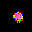

In [61]:
x[-5]

In [ ]:

ae_real_trained_l2, image_array_ae_real_l2, train_loss_avg_ae_real_l2 = train(lr=0.0001 ,train_dataloader = train_twoShape_dataloader ,num_epochs = 5,regularization = "l2")

In [ ]:
ae_real_trained, image_array_ae_real, train_loss_avg_ae_real = train(lr=0.0001 ,train_dataloader = train_dataloader ,num_epochs = 100)

In [ ]:
image_array_ae_real[-5]

In [ ]:
imrae_2_trained_real, image_array_imrae_2_real, train_loss_avg_imrae_2_trained_real = train(lr = 0.0001, train_dataloader = train_dataloader, num_epochs = 100, l = 2)

In [ ]:
imrae_4_trained, image_array_imrae_4, train_loss_avg_imrae_4_trained = train(lr = 0.0001, train_dataloader = train_dataloader, num_epochs = 10, l = 4)

In [ ]:
torch.save([MODEL_NAME}.state_dict(),"{FILENAME].pt")

In [33]:
def singular_values(irmae, test_dataloader,layers = 0):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    irmae.eval()
    z = []
    for batch in test_dataloader:
    
        num_matrices = 0
        
        with torch.no_grad():
            batch = batch.to(device)
            latent_vec = irmae.encoder(batch)
            if(layers > 0):
                z_portion = irmae.linear_between(latent_vec)
            else:
                z_portion = latent_vec
            z.append(z_portion)
    
    z = torch.cat(z,axis = 0).cpu().numpy()
    latent_covariance = np.cov(z,rowvar = False)
    
    
           
    _,diag,_ = np.linalg.svd(latent_covariance)
    return (diag/max(diag)),latent_covariance

In [ ]:
#using dataset with cv2 curcles but not cv2 rects
model = IMRAE(0)
model.load_state_dict(torch.load("ae_real_trained_colorsbtwen0and1_cv2circles.pt"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model2 = IMRAE(2)
model2.load_state_dict(torch.load("imrae_2_CVCircles.pt"))
model2.to(device)
model8 = IMRAE(4)
model8.load_state_dict(torch.load("imrae_4_trained_cvCircles.pt"))
model8.to(device)
diag_ae,_ = singular_values(model,test_dataloader)
diag_2,_ = singular_values(model2,test_dataloader)
diag_4,_ = singular_values(imrae_4_trained, test_dataloader)

In [76]:
#using dataset with cv2 circles abd cv2 squares (smaller)
#models are "ae_real_trained_CV2circles_smallerSquares.pt" and "imrae_2_trained_real_CV2circles_smallerSquares.pt"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model3 = IMRAE(0)
model3.load_state_dict(torch.load("ae_real_trained_CV2circles_smallerSquares.pt"))
model3.to(device)
model4 = IMRAE(2)
model4.load_state_dict(torch.load("imrae_2_trained_real_CV2circles_smallerSquares.pt"))
model4.to(device)
model5 = IMRAE(0)
model5.load_state_dict(torch.load("ae_real_trained_l1_cvcircles_smallrects.pt"))
model5.to(device)
model6 = IMRAE(0)
model6.load_state_dict(torch.load("ae_real_trained_l2_cvcircles_smallrects_encoderReg_1e-10.pt"))
model6.to(device)
model7 = IMRAE(0)
model7.load_state_dict(torch.load("ae_real_trained_l1_cvcircles_smallrects_encoderReg_1e-10_real.pt"))
model7.to(device)
diag_ae_real_trained, latent_cov_ae_real_train = singular_values(model3, test_dataloader)
diag_2_real_trained, latent_cov_2_real_trained = singular_values(model4, test_dataloader)
#ae_real_trained_l1_diag, cov_l1 = singular_values(model5, test_dataloader)
ae_real_trained_l2_diag,cov_l2 = singular_values(model6, test_dataloader)
#test_diag,_ = singular_values(ae_real_trained_l2,test_dataloader)
ae_real_trained_l1_diag, cov_l1 = singular_values(model7,test_dataloader)
imrae_4_diag, cov_4 = singular_values(imrae_4, test_dataloader)

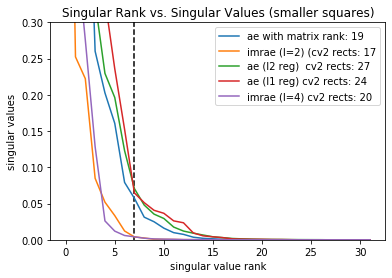

In [79]:

plt.plot(diag_ae_real_trained,label = f'ae with matrix rank: {torch.matrix_rank(torch.tensor(latent_cov_ae_real_train))}')
plt.plot(diag_2_real_trained, label = f"imrae (l=2) (cv2 rects: {torch.matrix_rank(torch.tensor(latent_cov_2_real_trained))}")
plt.plot(ae_real_trained_l2_diag, label = f"ae (l2 reg)  cv2 rects: {torch.matrix_rank(torch.tensor(cov_l2))}")
plt.plot(ae_real_trained_l1_diag, label = f"ae (l1 reg) cv2 rects: {torch.matrix_rank(torch.tensor(cov_l1))}")
plt.plot(imrae_4_diag, label = f"imrae (l=4) cv2 rects: {torch.matrix_rank(torch.tensor(cov_4))}")


plt.vlines(7,-1,1,linestyles = "dashed")
plt.ylim(0,0.3)
plt.ylabel('singular values')
plt.xlabel('singular value rank')
plt.title("Singular Rank vs. Singular Values (smaller squares)")
plt.legend()


In [ ]:

import torchvision.utils


def plt_images(image):
    to_pil_image= transforms.ToPILImage()
    plt.imshow(to_pil_image(image))

images,labels = iter(test_dataloader).next()

plt_images(torchvision.utils.make_grid(images[1:31],10,3))
plt.show()


In [71]:
import cv2 as cv
def interpolate(models,x):
    to_pil_image= transforms.ToPILImage()
    fig,axs = plt.subplots(len(models),len(x), figsize= (20,12))
    index = np.random.randint(30)
    images = iter(test_dataloader).next()
    images = images.to(device)
    row = 0
    for (model,name) in models:
        model.eval()
        z = model.linear_between(model.encoder(images))
        z1 = z[index]
        z2 = z[index+1]
        for b,i in enumerate(x):
            interpolated_image = i*z1 + (1-i) * z2
            ans = torch.reshape(model.decoder(interpolated_image),(3,32,32))
            ans_np = np.transpose(ans.cpu().detach().numpy(), [2,1,0])
            axs[row, b].imshow(ans_np)
            #axs[row, b].imshow(to_pil_image(torch.reshape(model.decoder(interpolated_image),(3,32,32)).cpu()))
            axs[row, b].set_title(f'{name}, x:{np.round(i,decimals = 1)}',fontdict = {'fontsize':8})
        row+=1
            
            

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

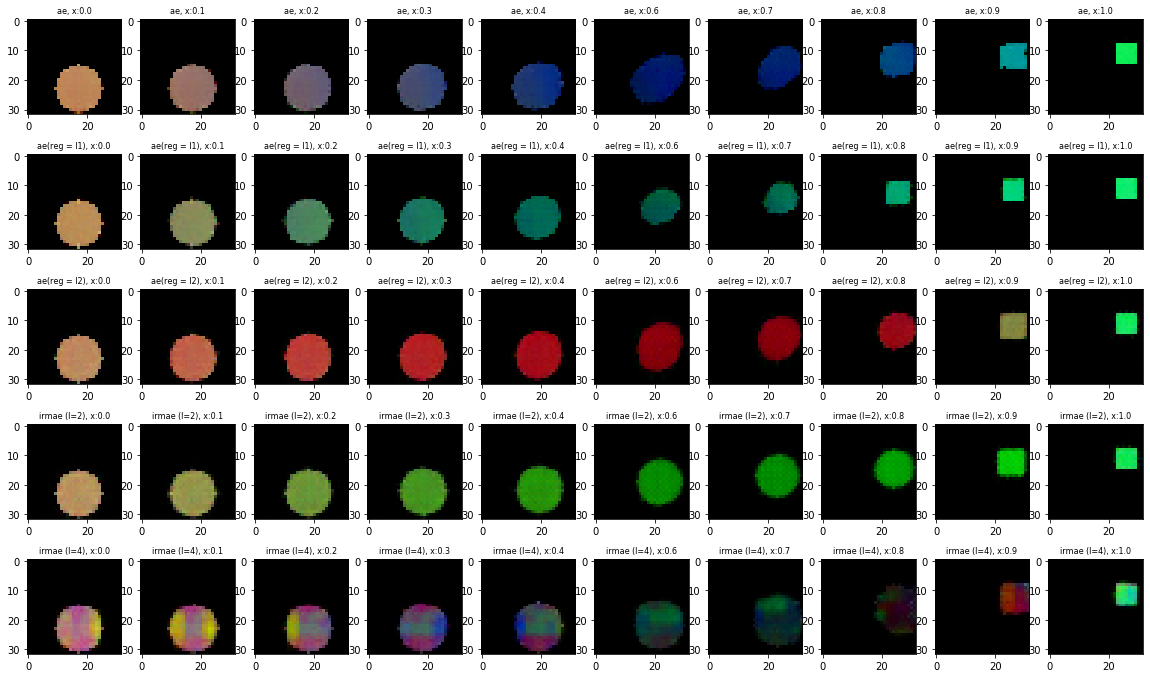

In [73]:
model = IMRAE(0)
model.load_state_dict(torch.load("ae_real_trained_colorsbtwen0and1_cv2circles.pt"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model2 = IMRAE(2)
model2.load_state_dict(torch.load("imrae_2_CVCircles.pt"))
model2.to(device)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model8 = IMRAE(4)
model8.load_state_dict(torch.load("imrae_4_trained_cvCircles.pt"))
model8.to(device)
model9 = IMRAE(0)
model9.load_state_dict(torch.load("ae_real_trained_l1_cvcircles_encoderReg_1e-10_real.pt"))
model9.to(device)
model10 = IMRAE(0)
model10.load_state_dict(torch.load("ae_real_trained_l2_cvcircles_encoderReg_1e-10.pt"))
model10.to(device)



model3 = IMRAE(0)
model3.load_state_dict(torch.load("ae_real_trained_CV2circles_smallerSquares.pt"))
model3.to(device)
model4 = IMRAE(2)
model4.load_state_dict(torch.load("imrae_2_trained_real_CV2circles_smallerSquares.pt"))
model4.to(device)
model6 = IMRAE(0)
model6.load_state_dict(torch.load("ae_real_trained_l2_cvcircles_smallrects_encoderReg_1e-10.pt"))
model6.to(device)
model7 = IMRAE(0)
model7.load_state_dict(torch.load("ae_real_trained_l1_cvcircles_smallrects_encoderReg_1e-10_real.pt"))
model7.to(device)
model8 = IMRAE(4)
model8.load_state_dict(torch.load("imrae_4_cvCircles_cvRectangles_lastOne_real.pt"))
model8.to(device)


interpolate([(model3,"ae"),(model7,"ae(reg = l1)"),(model6,"ae(reg = l2)"),(model4,"irmae (l=2)"),(model8,"irmae (l=4)")],np.round(np.linspace(0,1,10),decimals = 1))